In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from lightonopu.opu import OPU
from lightonml.random_projections.opu import OPURandomMapping

In [2]:
def make_x1_x2(n):
    x1 = np.random.choice([0,1], size=n**2, p=[0.75,0.25])
    x2 = np.random.choice([0,1], size=n**2, p=[0.5,0.5])
    
    x2[x1>0] = 0
    
    xs = np.vstack((x1,x2, x1+x2))
    
    return xs
    
def make_anchors(n, xs, number_of_anchors):
    anchors = np.zeros([number_of_anchors, n**2])
    
    anchor_p = [0.8,0.2]
    anchors[0] = np.random.choice([0,1], size=n**2, p=anchor_p) + xs[2]
    
    for i in range(1, number_of_anchors):
        anchors[i] = np.random.choice([0,1], size=n**2, p=anchor_p) + anchors[i-1]

    anchors[anchors>0] = 1
    anchors = anchors[::-1] # for convenience
    
    return anchors

def interfere_with_anchors(n, x, anchors):
    interfered = anchors - x
    interfered = np.vstack((interfered, x)) # x with zero (zero is less than x so subtract the other way)
    
    anchors = np.vstack((anchors, np.zeros(n**2))) # zero is an anchor too
    
    for i in range(anchors.shape[0]-1):
        diffs = anchors[i] - anchors[1+i:]
        interfered = np.vstack((interfered, diffs))
    
    return interfered

In [3]:
image_size = 64
number_of_anchors = 15
num_of_rows_in_A = 100

xs = make_x1_x2(image_size)
anchors = make_anchors(image_size, xs, number_of_anchors)

x1_inter = interfere_with_anchors(image_size, xs[0], anchors)
x2_inter = interfere_with_anchors(image_size, xs[1], anchors)
x1_plus_x2_inter = interfere_with_anchors(image_size, xs[2], anchors)

opu_input = np.vstack((x1_inter, x2_inter, x1_plus_x2_inter))

In [4]:
def get_OPU_measurements(opu_input, num_rand_proj):
    opu = OPU(500, 275) # exposure needs to be chosen so that there is no saturation.
    mapping = OPURandomMapping(opu, n_components=num_rand_proj)
    y = mapping.fit_transform(opu_input.astype('uint8'))
    print ('Max value:', np.max(y))
    print ('Min value: ', np.min(y))
    
    return y

y_quant = get_OPU_measurements(opu_input, num_of_rows_in_A)

OPU transform:   0%|          | 0/408 [00:00<?, ?it/s]

OPU: random projections of an array of size (408,4096)


OPU transform: 100%|██████████| 408/408 [00:01<00:00, 362.36it/s]


Max value: 231
Min value:  6


In [5]:
def make_D_ensembles(y, number_of_anchors):
    num_elements = int((number_of_anchors+2)* (number_of_anchors+1) * 0.5)
    
    trials = y.shape[1]
    dim = number_of_anchors+2
    all_D_oracles_x1 = np.zeros([trials, dim, dim])
    all_D_oracles_x2 = np.zeros([trials, dim, dim])
    all_D_oracles_x1_plus_x2 = np.zeros([trials, dim, dim])
    
    ind = np.triu_indices(all_D_oracles_x1[0].shape[0], k=1)
    for i in range(trials):
        data = y[0:num_elements,i]
        all_D_oracles_x1[i][ind] = data
        all_D_oracles_x1[i] += all_D_oracles_x1[i].T
        
        data = y[num_elements: 2*num_elements,i]
        all_D_oracles_x2[i][ind] = data
        all_D_oracles_x2[i] += all_D_oracles_x2[i].T
        
        data = y[2*num_elements: 3*num_elements,i]
        all_D_oracles_x1_plus_x2[i][ind] = data
        all_D_oracles_x1_plus_x2[i] += all_D_oracles_x1_plus_x2[i].T
        
    return all_D_oracles_x1, all_D_oracles_x2, all_D_oracles_x1_plus_x2

def do_MDS(D, number_of_anchors):
    m = number_of_anchors
    J = np.eye(m + 2) - 1. / (m + 2) * np.ones((m + 2, m + 2))
    G = -1/2 * np.dot(J, D).dot(J)
    U, s, VT = np.linalg.svd(G)
    Z_est_R2 = np.dot(np.diag(np.sqrt(s[:2])), VT[:2, :])
    Z_est_cpx = Z_est_R2[0, :] + 1j*Z_est_R2[1, :]
    
    # translate the origin back at (0, 0)
    Z_est_cpx -= Z_est_cpx[m + 1]
    
    return Z_est_cpx

def ortho_procrustes(fixed, modify):
    fixed = np.vstack ((np.real(fixed[1:]), np.imag(fixed[1:])))
    modify = np.vstack ((np.real(modify), np.imag(modify)))
    original = modify.copy()
    modify = modify[:,1:]
    fixed_mean = (np.mean(fixed, axis=1)).reshape([-1,1])
    fixed -= fixed_mean
    modify_mean = (np.mean(modify, axis=1)).reshape([-1,1])
    modify -= modify_mean
    M = fixed @ modify.T
    u, s, vh = np.linalg.svd(M)
    R = u @ vh
    original = R @ (original - modify_mean @ np.ones([1, original.shape[1]])) + fixed_mean@np.ones([1, original.shape[1]])
    return original[0] + 1j*original[1]

In [6]:
def make_LXX(X):
    e = np.ones([X.shape[1],1])
    G = X.T @ X
    diag_vec = np.diag(G).reshape([-1,1])
    L =  diag_vec @ e.T + e @ diag_vec.T - 2*G
    return L
    
def gradient_descent_X(D, X_0, W):
    lr = 0.001

    if (np.isnan(lr)):
        lr = 0
    if (np.isinf(lr)):
        lr = 0 

    n_iter = 20
    
    N = X_0.shape[1]
    e = np.ones([N,1])
    
    X = X_0.copy()
    
    for i in range(n_iter):
        L = make_LXX(X)
        P = D - L
        P = W*P
        grad = (1/N**2) * (8 * X @ (P - np.diag(np.diag(P @ e)) ))
        X -= lr*grad

    return X, L

In [7]:
all_D_quant_x1, all_D_quant_x2, all_D_quant_x1_plus_x2 = make_D_ensembles(y_quant, number_of_anchors)
    
manual = np.zeros([num_of_rows_in_A, number_of_anchors+1-2]).astype('complex128')
direct = np.zeros([num_of_rows_in_A, number_of_anchors+1-2]).astype('complex128')
manual_gd = np.zeros([num_of_rows_in_A, number_of_anchors+1-2]).astype('complex128')
direct_gd = np.zeros([num_of_rows_in_A, number_of_anchors+1-2]).astype('complex128')

for trial in tqdm(range(num_of_rows_in_A)):
    for i in range(2,number_of_anchors+1):
        ind = np.random.choice(np.arange(1, number_of_anchors+1), i, replace=False)
        ind = np.hstack((ind,0,number_of_anchors+1))
        ind.sort()

        D_quant_x1 = all_D_quant_x1[:,:,ind][trial][ind,:]
        D_quant_x2 = all_D_quant_x2[:,:,ind][trial][ind,:]
        D_quant_x1_plus_x2 = all_D_quant_x1_plus_x2[:,:,ind][trial][ind,:]

        # normal MDS
        recovered_points_x1 = do_MDS(D_quant_x1, i)
        recovered_points_x2 = do_MDS(D_quant_x2, i)
        recovered_points_x1_plus_x2 = do_MDS(D_quant_x1_plus_x2, i)
        recovered_points_x2 = ortho_procrustes(recovered_points_x1, recovered_points_x2)
        recovered_points_x1_plus_x2 = ortho_procrustes(recovered_points_x1, recovered_points_x1_plus_x2)

        manual_sum = recovered_points_x1[0] + recovered_points_x2[0]
        opu_sum = recovered_points_x1_plus_x2[0]
        manual[trial, i-2] = manual_sum
        direct[trial, i-2] = opu_sum

        # grad descent
        floor = np.min(y_quant)
    
        X_0 = np.vstack((np.real(recovered_points_x1), np.imag(recovered_points_x1)))
        W = (D_quant_x1>floor).astype('float') + np.eye(D_quant_x1.shape[0])
        X, L = gradient_descent_X(D_quant_x1, X_0, W)
        recovered_points_x1 = X[0] + 1j*X[1]
        recovered_points_x1 -= recovered_points_x1[-1]

        X_0 = np.vstack((np.real(recovered_points_x2), np.imag(recovered_points_x2)))
        W = (D_quant_x2>floor).astype('float') + np.eye(D_quant_x2.shape[0])
        X, L = gradient_descent_X(D_quant_x2, X_0, W)
        recovered_points_x2 = X[0] + 1j*X[1]
        recovered_points_x2 -= recovered_points_x2[-1]

        X_0 = np.vstack((np.real(recovered_points_x1_plus_x2), np.imag(recovered_points_x1_plus_x2)))
        W = (D_quant_x1_plus_x2>floor).astype('float') + np.eye(D_quant_x1_plus_x2.shape[0])
        X, L = gradient_descent_X(D_quant_x1_plus_x2, X_0, W)
        recovered_points_x1_plus_x2 = X[0] + 1j*X[1]
        recovered_points_x1_plus_x2 -= recovered_points_x1_plus_x2[-1]

        recovered_points_x2 = ortho_procrustes(recovered_points_x1, recovered_points_x2)
        recovered_points_x1_plus_x2 = ortho_procrustes(recovered_points_x1, recovered_points_x1_plus_x2)

        manual_sum = recovered_points_x1[0] + recovered_points_x2[0]
        opu_sum = recovered_points_x1_plus_x2[0]
        manual_gd[trial, i-2] = manual_sum
        direct_gd[trial, i-2] = opu_sum

100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


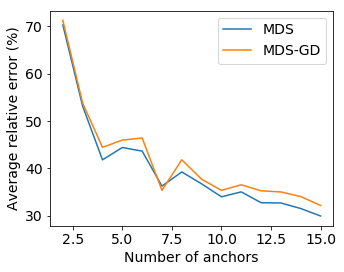

In [8]:
mask = (np.abs(direct)>2).astype('int')
mask_sum = (np.sum(mask, axis=0))

mask_gd = (np.abs(direct_gd)>2).astype('int')
mask_sum_gd = (np.sum(mask_gd, axis=0))

anchors_for_plot = np.arange(2, number_of_anchors+1)
rel_errors = 100*(np.abs(manual - direct) / np.abs(direct))
rel_errors_gd = 100*(np.abs(manual_gd - direct_gd) / np.abs(direct_gd))
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(5,4))

rel_errors = np.sum(rel_errors*mask, axis=0) / mask_sum
rel_errors_gd = np.sum(rel_errors_gd*mask_gd, axis=0) /mask_sum_gd

plt.plot(anchors_for_plot, rel_errors, label='MDS')
plt.plot(anchors_for_plot, rel_errors_gd, label='MDS-GD')

plt.ylabel('Average relative error (%)')
plt.xlabel('Number of anchors')
plt.legend()
plt.tight_layout()